# First things first
Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.

# Expectation-maximization algorithm

In this assignment, we will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. 

### Setup
Loading auxiliary files and importing the necessary libraries.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week2()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-09-29 08:31:05--  https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232 (1.2K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.20K  --.-KB/s    in 0s      

2020-09-29 08:31:05 (50.1 MB/s) - ‘setup_google_colab.py’ saved [1232/1232]

https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week2/w2_grader.py w2_grader.py
https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week2/samples.npz samples.npz


In [ ]:
import numpy as np
from numpy.linalg import slogdet, det, solve, inv
import matplotlib.pyplot as plt
import time
import math
from sklearn.datasets import load_digits
from w2_grader import EMGrader
from scipy.stats import multivariate_normal

%matplotlib inline

### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to the platform only after running submitting function in the last part of this assignment. If you want to make a partial submission, you can run that cell anytime you want.

In [ ]:
grader = EMGrader()

## Implementing EM for GMM

For debugging, we will use samples from a Gaussian mixture model with unknown mean, variance, and priors. We also added initial values of parameters for grading purposes.

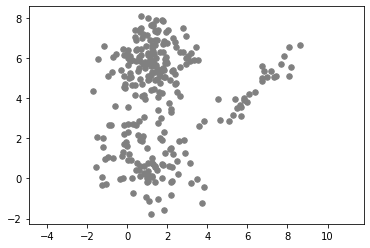

In [ ]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned, i.e. $t_i$  is the cluster index for object $x_i$.

The joint distribution can be written as follows: $\log p(T, X \mid \theta) =  \sum\limits_{i=1}^N \log p(t_i, x_i \mid \theta) = \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)\right)$,
where $f_{\!\mathcal{N}}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ is the probability density function (pdf) of the normal distribution $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q_i(t_i) = p(t_i \mid x_i, \theta)$. We assume that $t_i$ equals to the cluster index of the true component of the $x_i$ object. To do so we need to compute $\gamma_{ic} = p(t_i = c \mid x_i, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{y_i}}{\sum_j e^{y_j}}$, which is called _softmax_. When you compute exponents of large numbers, some numbers may become infinity. You can avoid this by dividing numerator and denominator by $e^{\max(y)}$: $\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. So, to compute desired formula you first subtract maximum value from each component in vector $\mathbf{y}$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to directly solve equation $Ay = x$ by using a special function. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by methods which do not explicitely invert the matrix. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [ ]:
def pdf(x,sigma,mu,d):
  f_N=(2*math.pi**d*det(sigma))**(-1/2)*np.exp(-1/2*np.dot(np.dot(np.transpose(x-mu),inv(sigma)),x-mu))
  return f_N
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
     
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    ### YOUR CODE HERE
    for i in range(0,N):
      for t in range(0,C):
        gamma[i][t]=pi[t]*pdf(X[i,:],sigma[t,:,:],mu[t,:],2) #pi[t] was missing
      gamma[i,:]=gamma[i,:]/np.sum(gamma[i,:])

    return gamma

In [ ]:
gamma = E_step(X, pi0, mu0, sigma0)
grader.submit_e_step(gamma)

Current answer for task Task 1 (E-step) is: 0.5337178741081263


### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [ ]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    mu=np.zeros((C,d))
    mu_upper_all=np.dot(np.transpose(gamma),X) #C*d
    for t in range(0,C):
      mu_upper=mu_upper_all[t,:]
      mu_lower=sum(gamma[:,t])
      mu[t,:] = mu_upper/mu_lower
    
    sigma=np.zeros((C,d,d))
    for t in range(0,C):
      sigma_upper=np.zeros((d,d)) #this was missing in previous implementation, causing wrong output
      for i in range(0,N):
        temp_matrix=X[i,:]-mu[t,:]
        sigma_upper += np.dot(temp_matrix.reshape([d,1]),temp_matrix.reshape([1,d]))*gamma[i,t] #d*d
      sigma_lower = sum(gamma[:,t])
      sigma[t,:,:]=sigma_upper/sigma_lower 
    
    """
    #someone else's codes
    for i in range(C):
      numerator_sigma=[]
      for j in range(N):
        numerator_sigma.append(gamma[j,i]*np.outer(X[j]-mu[i],X[j]-mu[i]))
      sigma[i]=(1/sum(gamma[:,i]))*sum(numerator_sigma)
    """

    pi=np.zeros((C))
    for t in range(0,C):
      pi[t]=sum(gamma[:,t])/sum(sum(gamma))

    return pi, mu, sigma

In [ ]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
print(pi,mu,sigma)
grader.submit_m_step(pi, mu, sigma)

[0.44702322 0.55076245 0.00221433] [[ 1.05852748  5.40759435]
 [ 2.16796132  2.89939188]
 [-1.33306197  1.41522785]] [[[ 0.70631457  1.00189734]
  [ 1.00189734  3.09525744]]

 [[ 5.76353448  1.49049001]
  [ 1.49049001  5.97710522]]

 [[ 0.0676037  -0.21186747]
  [-0.21186747  3.29922798]]]
Current answer for task Task 2 (M-step: mu) is: 2.8993918820503817
Current answer for task Task 2 (M-step: sigma) is: 5.977105216897524
Current answer for task Task 2 (M-step: pi) is: 0.5507624459218776


### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) (\log \pi_c + \log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)) - \sum_{i=1}^{N} \sum_{c=1}^{K} q(t_i =c) \log q(t_i =c)$$

In [ ]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    
    L_part1=0
    L_part2=0
    for i in range(0,N):
      for t in range(0,C):
        #L_part1+=gamma[i,t]*(np.log(pi[t])+np.log(pdf(x=X[i,:],sigma=sigma[t,:,:],mu=mu[t,:],d=d))) # my previous code, lead to Inf
        L_part1+=gamma[i,t]*(np.log(pi[t])+multivariate_normal.logpdf(X[i,:],mean=mu[t],cov=sigma[t]))
        L_part2+=gamma[i,t]*np.log(gamma[i,t])
    loss=L_part1-L_part2

    return loss
    """
    loss=0
    for i in range(N):
      for c in range(C):
        qt=gamma[i,c]
        pic=pi[c]
        xi=X[i,:]
        lic=qt*(np.log(pic)+multivariate_normal.logpdf(xi, mean=mu[c], cov=sigma[c]))-qt*np.log(qt)
        loss+=lic
    return loss
    """


In [ ]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
grader.submit_VLB(loss)

Current answer for task Task 3 (VLB) is: -1213.9734643060178


### Bringing it all together

Now that we have E step, M step and VLB, we can implement the training loop. We will initialize values of $\pi$, $\mu$ and $\Sigma$ to some random numbers, train until $\mathcal{L}$ stops changing, and return the resulting points. We also know that the EM algorithm converges to local optima. To find a better local optima, we will restart the algorithm multiple times from different (random) starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that initial (random) values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to restart the procedure.

<b>Task 4:</b> Implement training procedure

In [ ]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):#100,10
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            ### YOUR CODE HERE
            #pi=pi0
            #mu=mu0
            #sigma=sigma0
            
            pi = np.random.rand(C)
            pi = pi/sum(pi)
            mu = np.random.randint(low=-2,high=2,size=(C,d)) #randint(low[, high, size])
            sigma = sigma0
            counter=0
            loss_past=-1000
            #print(mu)
            
            while counter<max_iter:
              counter = counter+1
              gamma = E_step(X, pi, mu, sigma)
              pi, mu, sigma = M_step(X, gamma)
              loss_current = compute_vlb(X, pi, mu, sigma, gamma)
              print(loss_current)

              if abs((loss_current-loss_past)/loss_past)>rtol:
                loss_past=loss_current
              else:
                best_loss=loss_current
                best_pi=pi
                best_mu=mu
                best_sigma=sigma
                break
            

        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [ ]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
grader.submit_EM(best_loss)
print(best_pi,best_mu,best_sigma)

-1253.6384386023728
-1192.3983399531112
-1164.7393471955684
-1144.1565067216425
-1130.353971289534
-1121.8755468143083
-1116.308941846705
-1111.8187200823534
-1107.5556483093658
-1103.0862706893179
-1098.5222506113926
-1094.156094467024
-1090.2404416031088
-1087.1172780814516
-1084.69065279644
-1082.4702443219478
-1079.9609739955706
-1076.5208154670547
-1071.354177288862
-1066.7183489178603
-1065.1108527944918
-1064.4444052714284
-1271.0297902380223
-1218.8812985703382
-1198.607351160314
-1177.7832198748858
-1154.1049215759156
-1136.036615290303
-1126.746828905688
-1120.9587878205896
-1116.069769448209
-1111.3402765692788
-1106.607468634865
-1102.0095273171796
-1097.7467388346258
-1093.7837165679218
-1090.1220958422634
-1087.0984094180126
-1084.7864106456684
-1082.6785921076112
-1080.1716105793596
-1076.5122378834103
-1070.6426551915777
-1065.829834278879
-1064.6216860289978
-1064.1562520450352
-1255.1560718275541
-1223.9423820941845
-1211.7385731832135
nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


-1280.161367819413
nan
-1275.3996937375593
-1225.6124658535723
-1207.0853462852078
-1193.6778061196803
nan
-1203.9083713596817
nan
-1217.152415887557
-1186.675244384625
-1168.699233535412
-1159.043842316626
-1153.261746161309
-1148.3210788566673
-1143.3687367617629
-1138.2706260619696
-1133.0385857342476
-1127.833682547826
-1122.8478891331488
-1118.1490763343013
-1113.8512251619677
-1109.9883213087614
-1106.1790713880857
-1101.6863575565378
-1095.8810246256535
-1088.6866650132035
-1081.8109186447778
-1076.3347787916625
-1072.3925845658528
-1069.716417244395
-1067.7437563268838
-1066.4911339732803
-1065.5863131226697
-1206.8107127244582
-1180.0002434487897
-1173.6772704878438
-1169.6188744933083
-1165.6588750606575
-1160.8083218341505
-1154.4790025268514
-1146.5510655510489
-1137.6960453515323
-1130.8436202605176
-1125.584308280829
-1120.8599935702193
-1116.1651752900466
-1111.0691149050342
-1105.0856030784605
-1098.4929600428368
-1093.073491836806
-1089.3100748372985
-1086.449976069657

If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using a matrix $\gamma$ computed on last E-step. 

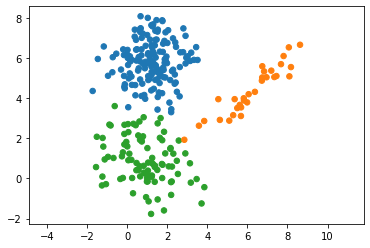

In [ ]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
plt.scatter(X[:, 0], X[:, 1], c=colors[labels], s=30)
plt.axis('equal')
plt.show()

# Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate a token on this programming assignment's page. <b>Note:</b> The token expires 30 minutes after generation.

In [ ]:
STUDENT_EMAIL = ""# EMAIL HERE
STUDENT_TOKEN = ""# TOKEN HERE
grader.status()

You want to submit these numbers:
Task Task 1 (E-step): 0.5337178741081263
Task Task 2 (M-step: mu): 2.8993918820503817
Task Task 2 (M-step: sigma): 5.977105216897524
Task Task 2 (M-step: pi): 0.5507624459218776
Task Task 3 (VLB): -1213.9734643060187
Task Task 4 (EM): -1065.7031633380846


If you want to submit these answers, run cell below

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
